In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

fs = 200000

class AdaptiveFilter(nn.Module):
    def __init__(self, input_channels, filter_size):
        super(AdaptiveFilter, self).__init__()

        # Initial convolution layer with increased filters
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=filter_size, padding='same')
        self.prelu1 = nn.PReLU()

        # Branch 1: Convolution layers followed by output layer
        self.branch1_layers = nn.ModuleList([
            nn.Conv1d(in_channels=64 if i == 0 else 64, out_channels=64, kernel_size=filter_size, padding='same') 
            for i in range(4)
        ])
        self.branch1_prelus = nn.ModuleList([nn.PReLU() for _ in range(4)])
        self.out1 = nn.Conv1d(in_channels=64, out_channels=input_channels, kernel_size=filter_size, padding='same')
        
        # Branch 2: Convolution layers followed by output layer
        self.branch2_layers = nn.ModuleList([
            nn.Conv1d(in_channels=64 if i == 0 else 64, out_channels=64, kernel_size=filter_size, padding='same') 
            for i in range(4)
        ])
        self.branch2_prelus = nn.ModuleList([nn.PReLU() for _ in range(4)])
        self.out2 = nn.Conv1d(in_channels=64, out_channels=input_channels, kernel_size=filter_size, padding='same')

    def forward(self, x):
        x_initial = self.prelu1(self.conv1(x))

        # Branch 1
        x_branch1 = self.branch1_prelus[0](self.branch1_layers[0](x_initial))
        x_branch1 = self.branch1_prelus[1](self.branch1_layers[1](x_branch1))
        x_branch1 = self.branch1_prelus[2](self.branch1_layers[2](x_branch1))
        x_branch1 = self.branch1_prelus[3](self.branch1_layers[3](x_branch1))
        out1 = self.out1(x_branch1)

        # Branch 2
        x_branch2 = self.branch2_prelus[0](self.branch2_layers[0](x_initial))
        x_branch2 = self.branch2_prelus[1](self.branch2_layers[1](x_branch2))
        x_branch2 = self.branch2_prelus[2](self.branch2_layers[2](x_branch2))
        x_branch2 = self.branch2_prelus[3](self.branch2_layers[3](x_branch2))
        out2 = self.out2(x_branch2)

        return out1, out2



In [2]:
# Load the data
train_data = torch.load('./Data/train')
test_data = torch.load('./Data/test')


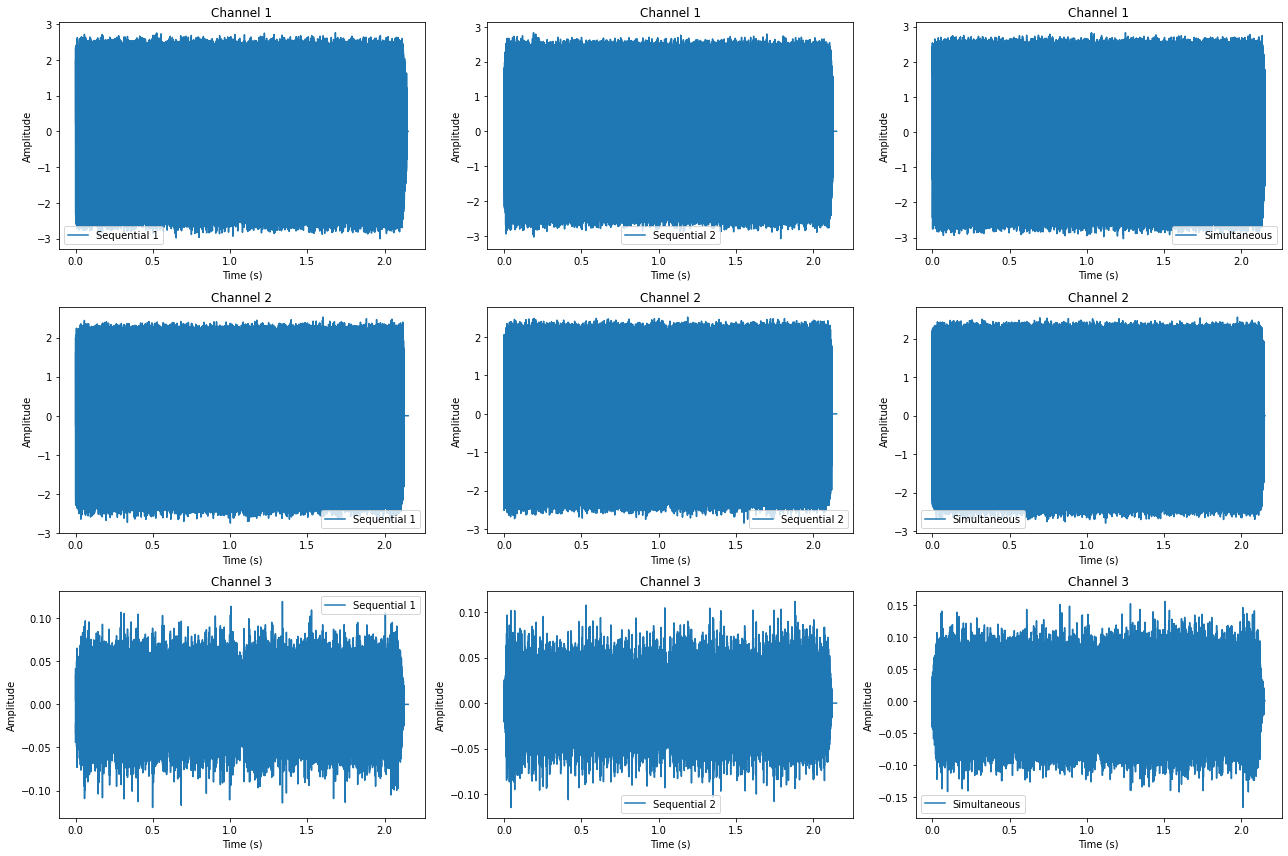

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Select a random key from the test_data
random_key = random.choice(list(test_data.keys()))

# Retrieve the data for the selected key
data = test_data[random_key]
sequential_data = data['sequential']
simultaneous_data = data['simultaneous']
mode = data['mode']

# Plot all channels for both sequential and simultaneous signals
# The structure is (2, num_channels, N) for sequential and (1, num_channels, N) for simultaneous

num_channels = sequential_data.shape[1]
N = sequential_data.shape[2]
time_vector = np.linspace(0, N / fs, N, endpoint=False)  # Sampling rate of 200kHz

# Create plots
fig, axs = plt.subplots(num_channels, 3, figsize=(18, 4 * num_channels))  # 3 plots per channel

for channel_idx in range(num_channels):
    # Plot sequential signals
    axs[channel_idx, 0].plot(time_vector, sequential_data[0, channel_idx, :].numpy(), label="Sequential 1")
    axs[channel_idx, 1].plot(time_vector, sequential_data[1, channel_idx, :].numpy(), label="Sequential 2")
    
    # Plot simultaneous signal
    axs[channel_idx, 2].plot(time_vector, simultaneous_data[0, channel_idx, :].numpy(), label="Simultaneous")
    
    for j in range(3):
        axs[channel_idx, j].set_title(f"Channel {channel_idx+1}")
        axs[channel_idx, j].legend()
        axs[channel_idx, j].set_xlabel("Time (s)")
        axs[channel_idx, j].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [4]:
def preload_data_to_cuda(train_data):
    preloaded_data = []
    file_names = []  # List to store file names
    for key, data in train_data.items():
        # Assuming 'simultaneous' and 'sequential' are the keys in your data dictionary
        simultaneous = data['simultaneous'].to(device)
        sequential = data['sequential'].to(device)
        preloaded_data.append((simultaneous, sequential))
        file_names.append(key)  # Store the file name (key) associated with this data
    return preloaded_data, file_names


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
# Initialize the model
filter_size = 5001  
model = AdaptiveFilter(input_channels=3, filter_size=filter_size)
model

AdaptiveFilter(
  (conv1): Conv1d(3, 64, kernel_size=(5001,), stride=(1,), padding=same)
  (prelu1): PReLU(num_parameters=1)
  (branch1_layers): ModuleList(
    (0-3): 4 x Conv1d(64, 64, kernel_size=(5001,), stride=(1,), padding=same)
  )
  (branch1_prelus): ModuleList(
    (0-3): 4 x PReLU(num_parameters=1)
  )
  (out1): Conv1d(64, 3, kernel_size=(5001,), stride=(1,), padding=same)
  (branch2_layers): ModuleList(
    (0-3): 4 x Conv1d(64, 64, kernel_size=(5001,), stride=(1,), padding=same)
  )
  (branch2_prelus): ModuleList(
    (0-3): 4 x PReLU(num_parameters=1)
  )
  (out2): Conv1d(64, 3, kernel_size=(5001,), stride=(1,), padding=same)
)

In [7]:
model.to(device)  # Ensure your model is on the correct device


AdaptiveFilter(
  (conv1): Conv1d(3, 64, kernel_size=(5001,), stride=(1,), padding=same)
  (prelu1): PReLU(num_parameters=1)
  (branch1_layers): ModuleList(
    (0-3): 4 x Conv1d(64, 64, kernel_size=(5001,), stride=(1,), padding=same)
  )
  (branch1_prelus): ModuleList(
    (0-3): 4 x PReLU(num_parameters=1)
  )
  (out1): Conv1d(64, 3, kernel_size=(5001,), stride=(1,), padding=same)
  (branch2_layers): ModuleList(
    (0-3): 4 x Conv1d(64, 64, kernel_size=(5001,), stride=(1,), padding=same)
  )
  (branch2_prelus): ModuleList(
    (0-3): 4 x PReLU(num_parameters=1)
  )
  (out2): Conv1d(64, 3, kernel_size=(5001,), stride=(1,), padding=same)
)

In [8]:
# Preload data to CUDA
preloaded_data, file_names = preload_data_to_cuda(train_data)


In [9]:
# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001)  # Learning rate of 0.001 as a starting point


In [10]:
import random

def train_model_preloaded(model, criterion, optimizer, preloaded_data, file_names, batch_size=4, epochs=10, save_path='./Models'):
    model.train()
    for epoch in range(epochs):
        # Reshuffle preloaded_data and file_names together to maintain association
        combined = list(zip(preloaded_data, file_names))
        random.shuffle(combined)
        shuffled_preloaded_data, shuffled_file_names = zip(*combined)
        
        running_loss = 0.0
        accumulated_loss = 0.0
        optimizer.zero_grad()  # Initialize gradient accumulation
        
        for i, ((inputs, targets_seq), file_name) in enumerate(zip(shuffled_preloaded_data, shuffled_file_names)):
            # Forward pass
            outputs_seq1, outputs_seq2 = model(inputs)
            loss1 = criterion(outputs_seq1, targets_seq.narrow(0, 0, 1))
            loss2 = criterion(outputs_seq2, targets_seq.narrow(0, 1, 1))
            loss = loss1 + loss2

            # Accumulate loss for verbosity and optimization
            accumulated_loss += loss.item()
            loss.backward()  # Accumulate gradients

            # Verbose output for the current file
            print(f"Epoch {epoch+1}, Processing {file_name}: Loss1 = {loss1.item():.4f}, Loss2 = {loss2.item():.4f}, Combined Loss = {loss.item():.4f}")

            if (i + 1) % batch_size == 0 or (i + 1) == len(shuffled_preloaded_data):
                # Update weights after accumulating batch_size files or at the end of the data
                optimizer.step()
                optimizer.zero_grad()  # Clear gradients for the next accumulation
                print(f"Epoch {epoch+1}, Batch {(i+1)//batch_size}, Average Batch Loss: {accumulated_loss/batch_size:.4f}")
                running_loss += accumulated_loss
                accumulated_loss = 0.0  # Reset accumulated loss for the next batch

        # Epoch summary
        average_loss = running_loss / len(shuffled_preloaded_data)
        print(f"Epoch {epoch+1}, Average Loss: {average_loss:.4f}")
        
        # Save the model at the end of each epoch
        epoch_save_path = f"{save_path}/model_epoch_cuda0_{epoch+1}.pth"
        torch.save(model.state_dict(), epoch_save_path)
        print(f"Model saved to {epoch_save_path}")





In [ ]:
# Define batch size and epochs
batch_size = 5
epochs = 1000

# Training
train_model_preloaded(model, criterion, optimizer, preloaded_data, file_names, batch_size=5, epochs=1000)


Epoch 1, Processing ('File_373', 'File_388'): Loss1 = 1.4823, Loss2 = 1.5338, Combined Loss = 3.0161
Epoch 1, Processing ('File_317', 'File_332'): Loss1 = 1.4706, Loss2 = 1.5271, Combined Loss = 2.9977
Epoch 1, Processing ('File_100', 'File_115'): Loss1 = 1.3788, Loss2 = 1.4221, Combined Loss = 2.8009
Epoch 1, Processing ('File_140', 'File_155'): Loss1 = 0.9533, Loss2 = 1.4930, Combined Loss = 2.4463
Epoch 1, Processing ('File_314', 'File_329'): Loss1 = 1.4832, Loss2 = 1.4731, Combined Loss = 2.9562
Epoch 1, Batch 1, Average Batch Loss: 2.8434
Epoch 1, Processing ('File_4', 'File_14'): Loss1 = 1.5083, Loss2 = 1.4556, Combined Loss = 2.9640
Epoch 1, Processing ('File_383', 'File_398'): Loss1 = 1.6264, Loss2 = 1.5867, Combined Loss = 3.2131
Epoch 1, Processing ('File_254', 'File_269'): Loss1 = 0.9229, Loss2 = 1.5392, Combined Loss = 2.4621
Epoch 1, Processing ('File_293', 'File_308'): Loss1 = 1.6268, Loss2 = 0.7667, Combined Loss = 2.3936
Epoch 1, Processing ('File_43', 'File_58'): Loss1

Epoch 1, Processing ('File_166', 'File_181'): Loss1 = 1.8580, Loss2 = 1.5815, Combined Loss = 3.4395
Epoch 1, Processing ('File_45', 'File_60'): Loss1 = 1.7301, Loss2 = 1.8307, Combined Loss = 3.5608
Epoch 1, Processing ('File_54', 'File_69'): Loss1 = 1.6805, Loss2 = 1.9507, Combined Loss = 3.6312
Epoch 1, Processing ('File_323', 'File_338'): Loss1 = 1.8537, Loss2 = 2.1360, Combined Loss = 3.9897
Epoch 1, Processing ('File_252', 'File_267'): Loss1 = 1.1620, Loss2 = 2.0717, Combined Loss = 3.2336
Epoch 1, Batch 16, Average Batch Loss: 3.5710
Epoch 1, Processing ('File_1', 'File_11'): Loss1 = 3.9737, Loss2 = 2.3283, Combined Loss = 6.3020
Epoch 1, Processing ('File_259', 'File_274'): Loss1 = 3.4521, Loss2 = 2.5816, Combined Loss = 6.0337
Epoch 1, Processing ('File_251', 'File_266'): Loss1 = 3.4373, Loss2 = 2.5509, Combined Loss = 5.9883
Epoch 1, Processing ('File_110', 'File_125'): Loss1 = 3.9298, Loss2 = 2.4070, Combined Loss = 6.3367
Epoch 1, Processing ('File_6', 'File_16'): Loss1 = 3

Epoch 2, Processing ('File_250', 'File_265'): Loss1 = 113.7178, Loss2 = 1.4773, Combined Loss = 115.1951
Epoch 2, Batch 2, Average Batch Loss: 114.1118
Epoch 2, Processing ('File_287', 'File_302'): Loss1 = 4.6656, Loss2 = 0.7503, Combined Loss = 5.4159
Epoch 2, Processing ('File_321', 'File_336'): Loss1 = 4.7630, Loss2 = 1.5570, Combined Loss = 6.3200
Epoch 2, Processing ('File_45', 'File_60'): Loss1 = 4.4667, Loss2 = 1.2848, Combined Loss = 5.7515
Epoch 2, Processing ('File_288', 'File_303'): Loss1 = 4.6384, Loss2 = 0.8242, Combined Loss = 5.4626
Epoch 2, Processing ('File_1', 'File_11'): Loss1 = 4.4888, Loss2 = 1.3482, Combined Loss = 5.8370
Epoch 2, Batch 3, Average Batch Loss: 5.7574
Epoch 2, Processing ('File_25', 'File_35'): Loss1 = 41.8381, Loss2 = 1.2665, Combined Loss = 43.1046
Epoch 2, Processing ('File_311', 'File_326'): Loss1 = 44.9842, Loss2 = 1.5004, Combined Loss = 46.4846
Epoch 2, Processing ('File_168', 'File_183'): Loss1 = 43.2780, Loss2 = 1.0131, Combined Loss = 44.2

Epoch 2, Processing ('File_320', 'File_335'): Loss1 = 107.7811, Loss2 = 1.4952, Combined Loss = 109.2764
Epoch 2, Processing ('File_20', 'File_30'): Loss1 = 100.9789, Loss2 = 1.3944, Combined Loss = 102.3733
Epoch 2, Batch 17, Average Batch Loss: 105.8957
Epoch 2, Processing ('File_323', 'File_338'): Loss1 = 30.6357, Loss2 = 1.5345, Combined Loss = 32.1702
Epoch 2, Processing ('File_319', 'File_334'): Loss1 = 30.5867, Loss2 = 1.5342, Combined Loss = 32.1209
Epoch 2, Processing ('File_257', 'File_272'): Loss1 = 28.9308, Loss2 = 1.5388, Combined Loss = 30.4696
Epoch 2, Processing ('File_259', 'File_274'): Loss1 = 28.8824, Loss2 = 1.5474, Combined Loss = 30.4298
Epoch 2, Processing ('File_381', 'File_396'): Loss1 = 30.7164, Loss2 = 1.5443, Combined Loss = 32.2607
Epoch 2, Batch 18, Average Batch Loss: 31.4902
Epoch 2, Processing ('File_375', 'File_390'): Loss1 = 31.3835, Loss2 = 1.5369, Combined Loss = 32.9203
Epoch 2, Processing ('File_8', 'File_18'): Loss1 = 29.2365, Loss2 = 1.3940, Com

Epoch 3, Processing ('File_20', 'File_30'): Loss1 = 25.7499, Loss2 = 1.3917, Combined Loss = 27.1416
Epoch 3, Processing ('File_54', 'File_69'): Loss1 = 25.5609, Loss2 = 1.3862, Combined Loss = 26.9471
Epoch 3, Processing ('File_111', 'File_126'): Loss1 = 25.9671, Loss2 = 1.2634, Combined Loss = 27.2305
Epoch 3, Processing ('File_52', 'File_67'): Loss1 = 25.4947, Loss2 = 1.3833, Combined Loss = 26.8780
Epoch 3, Batch 4, Average Batch Loss: 27.0421
Epoch 3, Processing ('File_384', 'File_399'): Loss1 = 60.4326, Loss2 = 1.5082, Combined Loss = 61.9409
Epoch 3, Processing ('File_167', 'File_182'): Loss1 = 58.7715, Loss2 = 0.9225, Combined Loss = 59.6939
Epoch 3, Processing ('File_45', 'File_60'): Loss1 = 56.8188, Loss2 = 1.2624, Combined Loss = 58.0811
Epoch 3, Processing ('File_40', 'File_55'): Loss1 = 56.5387, Loss2 = 1.3397, Combined Loss = 57.8784
Epoch 3, Processing ('File_294', 'File_309'): Loss1 = 57.5185, Loss2 = 0.7992, Combined Loss = 58.3176
Epoch 3, Batch 5, Average Batch Loss:

Epoch 3, Processing ('File_22', 'File_32'): Loss1 = 2.6457, Loss2 = 1.3837, Combined Loss = 4.0294
Epoch 3, Processing ('File_310', 'File_325'): Loss1 = 2.8746, Loss2 = 1.3663, Combined Loss = 4.2409
Epoch 3, Processing ('File_28', 'File_38'): Loss1 = 2.6426, Loss2 = 1.3828, Combined Loss = 4.0255
Epoch 3, Processing ('File_25', 'File_35'): Loss1 = 2.6966, Loss2 = 1.2525, Combined Loss = 3.9491
Epoch 3, Batch 19, Average Batch Loss: 3.9718
Epoch 3, Processing ('File_5', 'File_15'): Loss1 = 2.1570, Loss2 = 1.2722, Combined Loss = 3.4292
Epoch 3, Processing ('File_380', 'File_395'): Loss1 = 2.2809, Loss2 = 1.5050, Combined Loss = 3.7859
Epoch 3, Processing ('File_137', 'File_152'): Loss1 = 1.7516, Loss2 = 1.5280, Combined Loss = 3.2796
Epoch 3, Processing ('File_169', 'File_184'): Loss1 = 2.2423, Loss2 = 0.9217, Combined Loss = 3.1640
Epoch 3, Processing ('File_377', 'File_392'): Loss1 = 2.2726, Loss2 = 1.5320, Combined Loss = 3.8046
Epoch 3, Batch 20, Average Batch Loss: 3.4927
Epoch 3,

Epoch 4, Processing ('File_138', 'File_153'): Loss1 = 1.1306, Loss2 = 1.4901, Combined Loss = 2.6207
Epoch 4, Processing ('File_137', 'File_152'): Loss1 = 1.1666, Loss2 = 1.5279, Combined Loss = 2.6945
Epoch 4, Processing ('File_22', 'File_32'): Loss1 = 1.5175, Loss2 = 1.3835, Combined Loss = 2.9010
Epoch 4, Processing ('File_29', 'File_39'): Loss1 = 1.5684, Loss2 = 1.2532, Combined Loss = 2.8215
Epoch 4, Processing ('File_7', 'File_17'): Loss1 = 1.5858, Loss2 = 1.2660, Combined Loss = 2.8518
Epoch 4, Batch 6, Average Batch Loss: 2.7779
Epoch 4, Processing ('File_41', 'File_56'): Loss1 = 1.6318, Loss2 = 1.2388, Combined Loss = 2.8706
Epoch 4, Processing ('File_322', 'File_337'): Loss1 = 1.7727, Loss2 = 1.4923, Combined Loss = 3.2649
Epoch 4, Processing ('File_370', 'File_385'): Loss1 = 1.7834, Loss2 = 1.5025, Combined Loss = 3.2859
Epoch 4, Processing ('File_144', 'File_159'): Loss1 = 1.2395, Loss2 = 1.4966, Combined Loss = 2.7361
Epoch 4, Processing ('File_284', 'File_299'): Loss1 = 1

In [ ]:
def evaluate_model(model, criterion, test_data):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for key, data in test_data.items():
            inputs = data['simultaneous'].to(device)
            targets_seq = data['sequential'].to(device)
            
            # Forward pass
            outputs_seq1, outputs_seq2 = model(inputs)
            loss = criterion(outputs_seq1, targets_seq.narrow(0,0,1)) + criterion(outputs_seq2, targets_seq.narrow(0,1,1))
            total_loss += loss.item()
    
    print(f"Test Loss: {total_loss / len(test_data)}")


In [ ]:
# Evaluation
evaluate_model(model, criterion, test_data)

In [ ]:
# Model parameters
input_channels = 1  # Assuming 1 channel input for simplicity; adjust as necessary
output_channels = 1  # Outputting 2 separate channels, but each is treated as 1-channel output
filter_size = 5  # Example filter size; adjust as per requirement

# Initialize the model
model = AdaptiveFilter(input_channels=input_channels, output_channels=output_channels, filter_size=filter_size)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
